## 1. PyTorch Implementation with MCE

In [8]:
'''
Define model
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNNWithMCE(nn.Module):
    def __init__(self, hidden_size, activation_fn="sigmoid"):
        super(FFNNWithMCE, self).__init__()

        self.input_layer = nn.Linear(2, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, 2, bias=True)

        if activation_fn == "sigmoid":
            self.activation = torch.sigmoid
        elif activation_fn == "tanh":
            self.activation = torch.tanh
        elif activation_fn == "relu":
            self.activation = torch.relu

    def forward(self, x):
        hidden = self.activation(self.input_layer(x))
        output = self.output_layer(hidden)

        return output

In [9]:
'''
Train model
'''

import torch.optim as optim

def train_model(model, train_loader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss = 0
        for data, target in train_loader:
            target = target.long()
            optimizer.zero_grad() # reset gradients
            output = model(data) # forward pass
            loss = criterion(output, target) # calculate loss
 
            loss.backward() # backpropagation
            optimizer.step() # take step based on gradients and lr

            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

In [10]:
'''
Take in raw csv file path and batch size, return DataLoader object
'''

import csv
import torch
from torch.utils.data import DataLoader, TensorDataset

def load_data(file_path, batch_size):
    inputs = []
    labels = []

    with open(file_path, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header row
        for row in reader:
            labels.append(float(row[0]))
            inputs.append([float(row[1]), float(row[2])])

    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(inputs_tensor, labels_tensor)
    loader = DataLoader(dataset, batch_size=batch_size)

    return loader


In [11]:
'''
Train model with train set. 
'''

file_path = "xor_train.csv"

# Hyperparams
hidden_size = 7
batch_size = 8
activation_fn = "relu"
num_epochs = 100
learning_rate = 1

train_loader = load_data(file_path, batch_size)
model = FFNNWithMCE(hidden_size, activation_fn)

train_model(model, train_loader, num_epochs, learning_rate)

Epoch 1/100, Loss: 0.6700
Epoch 2/100, Loss: 0.5562
Epoch 3/100, Loss: 0.5099
Epoch 4/100, Loss: 0.4872
Epoch 5/100, Loss: 0.5524
Epoch 6/100, Loss: 0.4593
Epoch 7/100, Loss: 0.3997
Epoch 8/100, Loss: 0.8317
Epoch 9/100, Loss: 0.5248
Epoch 10/100, Loss: 0.5887
Epoch 11/100, Loss: 0.7615
Epoch 12/100, Loss: 0.4341
Epoch 13/100, Loss: 0.7144
Epoch 14/100, Loss: 0.6284
Epoch 15/100, Loss: 0.6364
Epoch 16/100, Loss: 0.6010
Epoch 17/100, Loss: 0.6753
Epoch 18/100, Loss: 0.7338
Epoch 19/100, Loss: 0.5658
Epoch 20/100, Loss: 0.6327
Epoch 21/100, Loss: 0.4301
Epoch 22/100, Loss: 0.4497
Epoch 23/100, Loss: 0.6314
Epoch 24/100, Loss: 0.6955
Epoch 25/100, Loss: 0.5043
Epoch 26/100, Loss: 0.6927
Epoch 27/100, Loss: 0.5197
Epoch 28/100, Loss: 0.8773
Epoch 29/100, Loss: 0.7960
Epoch 30/100, Loss: 0.6524
Epoch 31/100, Loss: 0.5982
Epoch 32/100, Loss: 0.6584
Epoch 33/100, Loss: 0.5261
Epoch 34/100, Loss: 0.4005
Epoch 35/100, Loss: 0.8705
Epoch 36/100, Loss: 0.9194
Epoch 37/100, Loss: 0.8292
Epoch 38/1

In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # between the probabilities for 0 and 1, pick higher
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.numpy())
            all_targets.extend(target.numpy())

    all_preds = torch.tensor(all_preds).squeeze()
    all_targets = torch.tensor(all_targets)
    
    correct = (all_preds == all_targets).sum().item()
    total = len(all_targets)
    accuracy = correct / total
    
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [13]:
eval_file_path = "xor_test.csv"
eval_batch_size = 4

eval_loader = load_data(eval_file_path, eval_batch_size)
evaluate_model(model, eval_loader)

Accuracy: 0.5250


0.525

In [14]:
import matplotlib.pyplot as plt

def plot_loss_curves(model, train_loader, val_loader, num_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_train_loss = 0.0
        for data, target in train_loader:
            target = target.long().squeeze()
            optimizer.zero_grad()
            output = model(data).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                target = target.long().squeeze()
                output = model(data).squeeze()
                loss = criterion(output, target)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses


Epoch 1/300 - Train Loss: 0.6907, Validation Loss: 0.4872
Epoch 2/300 - Train Loss: 0.5113, Validation Loss: 0.4874
Epoch 3/300 - Train Loss: 0.4942, Validation Loss: 0.4858
Epoch 4/300 - Train Loss: 0.4869, Validation Loss: 0.4847
Epoch 5/300 - Train Loss: 0.4820, Validation Loss: 0.4829
Epoch 6/300 - Train Loss: 0.4777, Validation Loss: 0.4820
Epoch 7/300 - Train Loss: 0.4761, Validation Loss: 0.4808
Epoch 8/300 - Train Loss: 0.4730, Validation Loss: 0.4830
Epoch 9/300 - Train Loss: 0.4693, Validation Loss: 0.4798
Epoch 10/300 - Train Loss: 0.4671, Validation Loss: 0.4817
Epoch 11/300 - Train Loss: 0.4633, Validation Loss: 0.4811
Epoch 12/300 - Train Loss: 0.4622, Validation Loss: 0.4808
Epoch 13/300 - Train Loss: 0.4597, Validation Loss: 0.4853
Epoch 14/300 - Train Loss: 0.4591, Validation Loss: 0.4866
Epoch 15/300 - Train Loss: 0.4572, Validation Loss: 0.4879
Epoch 16/300 - Train Loss: 0.4552, Validation Loss: 0.4808
Epoch 17/300 - Train Loss: 0.4548, Validation Loss: 0.4867
Epoch 

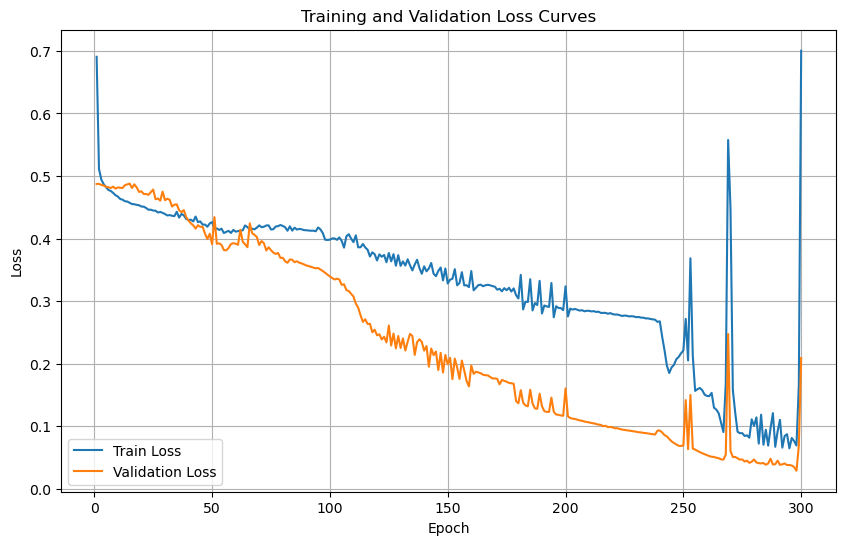

([0.690668077468872,
  0.5112781846523284,
  0.49417405724525454,
  0.4868947756290436,
  0.4820338559150696,
  0.47765062808990477,
  0.4761352276802063,
  0.47296955704689025,
  0.4693237996101379,
  0.46708364367485045,
  0.46328718662261964,
  0.4621575564146042,
  0.45966235518455506,
  0.4591487640142441,
  0.45716238260269165,
  0.45517177760601046,
  0.4548331016302109,
  0.45381236374378203,
  0.45323278367519376,
  0.45119462251663206,
  0.4509643316268921,
  0.44886249661445615,
  0.44606194138526917,
  0.44610493183135985,
  0.44476236283779147,
  0.4444661295413971,
  0.44160459816455844,
  0.44254973471164705,
  0.4410311561822891,
  0.43923009037971494,
  0.43690884828567506,
  0.43747819602489474,
  0.4364212077856064,
  0.435831401348114,
  0.44276150822639465,
  0.43347277760505676,
  0.43932281076908114,
  0.43716300308704376,
  0.4313816976547241,
  0.4294962537288666,
  0.4301129877567291,
  0.42732036173343657,
  0.43515683472156524,
  0.4262361079454422,
  0.4273

In [15]:
file_path = "xor_train.csv"

hidden_size = 7
batch_size = 8
activation_fn = "relu"
num_epochs = 300
learning_rate = 0.1

eval_file_path = "xor_valid.csv"
eval_batch_size = 4


train_loader = load_data(file_path, batch_size)
model = FFNNWithMCE(hidden_size, activation_fn)
eval_loader = load_data(eval_file_path, eval_batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

plot_loss_curves(model, train_loader, eval_loader, num_epochs, optimizer, criterion)


In [16]:
'''
Plot decision surface. 
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_decision_surface(model, test_loader, feature_range=(-2, 2), resolution=0.01):
    # Generate a grid of points
    x_min, x_max = feature_range
    y_min, y_max = feature_range
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten the grid to feed into the model
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
    
    # Get model predictions on the grid
    model.eval()
    with torch.no_grad():
        predictions = model(grid_points_tensor)
        print(predictions)
        predicted_labels = torch.argmax(predictions, axis=1).numpy()
        print(predicted_labels)
    
    # Reshape predictions back to the grid shape
    Z = predicted_labels.reshape(xx.shape)
    
    # Plot decision surface
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    
    # Plot test data points
    for data, target in test_loader:
        data = data.numpy()
        target = target.numpy()
        plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='k', cmap=plt.cm.coolwarm, s=50, label='Test Data')
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Class 0',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Class 1',
               markerfacecolor='blue', markersize=10)
    ]

    plt.title('Learned Decision Surface')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(handles=legend_elements, loc='upper right')
    plt.grid(True)
    plt.show()


tensor([[ 25.5500, -23.8840],
        [ 25.5417, -23.8786],
        [ 25.5333, -23.8731],
        ...,
        [-16.3760,  25.0533],
        [-16.3823,  25.0571],
        [-16.3887,  25.0608]])
[0 0 0 ... 1 1 1]


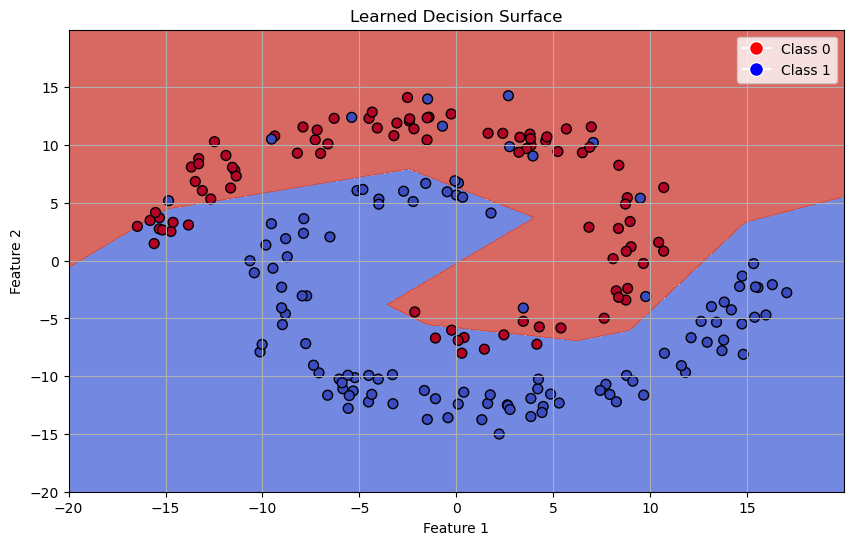

In [17]:
eval_file_path = "spiral_test.csv"
eval_batch_size = 4

test_loader = load_data(eval_file_path, eval_batch_size)
plot_decision_surface(model, test_loader, feature_range=(-20, 20), resolution=0.01)

## Q1 Response

### **i) xor**

#### a. 
- k=9
- batch_size=8
- num_epochs=300
- learning_rate=1
- activation_fn=sigmoid

#### b.
<img src="loss_curves/mce/xor.png" width="500">

#### c.
0.97

#### d.
<img src="decision_surface/mce/xor.png" width="500">

#### e. 
Keeping other hyperparameters constant (batch_size=8, activation=sigmoid, num_epochs=20, lr=1), I varied k (hidden_size) between 2, 3, 5, 7, and 9. The accuracy increased as we increased the value of k. k=9 was selected as it provided the best accuracy (0.905) without overfitting. I then increased the batch size to 16 and 32, which resulted in poorer performance. With 8 as the batch size and 9 as the size of the hidden layer, the learning rate of 1 resulted in higher accuracy than 0.1 or 0.01. The number of epochs was set to 300, because compared to lower numbers of epochs (e.g. 50 or 100), it gave a better performance. However, num_epochs of 500 showed a slight drop in accuracy, possibly due to overfitting.


### **ii) center_surround**

#### a. 
- k=7
- batch_size=16
- num_epochs=100
- learning_rate=1
- activation_fn=tanh

#### b.
<img src="loss_curves/mce/center_surround.png" width="500">

#### c.
0.77

#### d.
<img src="decision_surface/mce/center_surround.png" width="500">

#### e.
First, I varied the number of hidden nodes from 2 to 9 with batch_size=9, activation=sigmoid, num_epochs=50, and lr=1. Accuracy increased with k, peaking at 0.955 for k=7, which provided sufficient capacity without overfitting. Increasing the batch size to 16 improved accuracy to 0.965, while larger sizes showed no further gains. Using 100 epochs maintained the best performance (0.965), as extending to 200 epochs led to overfitting. A learning rate of 1 outperformed 0.1, enabling faster and more effective convergence. Testing activation functions, tanh achieved the highest accuracy (0.975) over sigmoid and ReLU. The final choice of k=7, batch_size=16, activation=tanh, num_epochs=50, and lr=1 delivered optimal results.

### **iii) two_gaussians**

#### a. 
- k=2
- batch_size=8
- num_epochs=50
- learning_rate=1
- activation_fn=sigmoid

#### b.
<img src="loss_curves/mce/two_gaussians.png" width="500">

#### c.
0.915

#### d.
<img src="decision_surface/mce/two_gaussians.png" width="500">

#### e.
I experimented with varying the number of hidden nodes (k) while keeping other hyperparameters constant (batch_size=8, num_epochs=50, learning_rate=1, activation=sigmoid). The accuracy reached 0.98 for k=2, 3, 7, and 9, with a slight drop to 0.975 for k=5. Since increasing k beyond 2 provided no improvement in accuracy, I selected k=2 as it achieved the desired performance of 0.98 with minimal model complexity. Given that batch_size=8, num_epochs=50, and learning_rate=1 consistently yielded strong results, and 0.98 was deemed satisfactory, further tuning was unnecessary. This choice ensured an efficient and effective configuration.

### **iv) spiral**

#### a. 
- k=5
- batch_size=8
- num_epochs=500
- learning_rate=0.1
- activation_fn=sigmoid

#### b.
<img src="loss_curves/mce/spiral.png" width="500">

#### c.
0.98

#### d.
<img src="decision_surface/mce/spiral.png" width="500">

#### e.
I varied the number of hidden nodes (k) with batch_size=8, num_epochs=50, learning_rate=1, and activation=sigmoid. The accuracy increased as k increased, peaking at 0.785 for k=5. Accuracy declined slightly for larger values of k, suggesting that k=5 provided the best balance between model capacity and performance. I then tested different batch sizes with k=5, finding that increasing the batch size to 16 and 32 resulted in lower accuracies (0.7 and 0.695, respectively), reinforcing that a smaller batch size of 8 was more effective. Next, I experimented with the number of epochs and learning rate. Increasing num_epochs from 100 to 500 with a reduced learning rate of 0.1 significantly improved accuracy to 0.965, but extending training to 1000 epochs caused a slight drop in performance to 0.915, likely due to overfitting. Based on these results, the best configuration was k=5, batch_size=8, num_epochs=500, learning_rate=0.1, and activation=sigmoid, achieving an accuracy of 0.965.


## 2. PyTorch Implementation with MSE

In [18]:
'''
Define model
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNNWithMSE(nn.Module):
    def __init__(self, hidden_size, activation_fn="sigmoid"):
        super(FFNNWithMSE, self).__init__()

        self.input_layer = nn.Linear(2, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, 1, bias=True)

        if activation_fn == "sigmoid":
            self.activation = torch.sigmoid
        elif activation_fn == "tanh":
            self.activation = torch.tanh
        elif activation_fn == "relu":
            self.activation = torch.relu

    def forward(self, x):
        hidden = self.activation(self.input_layer(x))
        output = torch.sigmoid(self.output_layer(hidden))

        return output

In [19]:
'''
Train model
'''

import torch.optim as optim

def train_model(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss = 0
        for data, target in train_loader:
            target = target.float().unsqueeze(1)
            optimizer.zero_grad() # reset gradients
            output = model(data) # forward pass
            loss = criterion(output, target) # calculate loss
 
            loss.backward() # backpropagation
            optimizer.step() # take step based on gradients and lr

            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

In [20]:
'''
Take in raw csv file path and batch size, return DataLoader object
'''

import csv
import torch
from torch.utils.data import DataLoader, TensorDataset

def load_data(file_path, batch_size):
    inputs = []
    labels = []

    with open(file_path, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header row
        for row in reader:
            labels.append(float(row[0]))
            inputs.append([float(row[1]), float(row[2])])

    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(inputs_tensor, labels_tensor)
    loader = DataLoader(dataset, batch_size=batch_size)

    return loader


In [21]:
'''
Train model with train set. 
Hyperparameters: hidden_size, batch_size, num_epochs, learning_rate
'''

file_path = "spiral_train.csv"

# Hyperparams
hidden_size = 7
batch_size = 8
activation_fn = "relu"
num_epochs = 300
learning_rate = 0.1

train_loader = load_data(file_path, batch_size)
model = FFNNWithMSE(hidden_size, activation_fn)

train_model(model, train_loader, num_epochs, learning_rate)

Epoch 1/300, Loss: 0.2191
Epoch 2/300, Loss: 0.1676
Epoch 3/300, Loss: 0.1643
Epoch 4/300, Loss: 0.1634
Epoch 5/300, Loss: 0.1610
Epoch 6/300, Loss: 0.1601
Epoch 7/300, Loss: 0.1599
Epoch 8/300, Loss: 0.1600
Epoch 9/300, Loss: 0.1595
Epoch 10/300, Loss: 0.1592
Epoch 11/300, Loss: 0.1591
Epoch 12/300, Loss: 0.1588
Epoch 13/300, Loss: 0.1587
Epoch 14/300, Loss: 0.1584
Epoch 15/300, Loss: 0.1582
Epoch 16/300, Loss: 0.1581
Epoch 17/300, Loss: 0.1582
Epoch 18/300, Loss: 0.1578
Epoch 19/300, Loss: 0.1578
Epoch 20/300, Loss: 0.1576
Epoch 21/300, Loss: 0.1574
Epoch 22/300, Loss: 0.1574
Epoch 23/300, Loss: 0.1573
Epoch 24/300, Loss: 0.1571
Epoch 25/300, Loss: 0.1570
Epoch 26/300, Loss: 0.1569
Epoch 27/300, Loss: 0.1567
Epoch 28/300, Loss: 0.1567
Epoch 29/300, Loss: 0.1565
Epoch 30/300, Loss: 0.1564
Epoch 31/300, Loss: 0.1563
Epoch 32/300, Loss: 0.1562
Epoch 33/300, Loss: 0.1563
Epoch 34/300, Loss: 0.1560
Epoch 35/300, Loss: 0.1557
Epoch 36/300, Loss: 0.1555
Epoch 37/300, Loss: 0.1554
Epoch 38/3

In [22]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # if output exceeds threshold 0.5, classify as 1
            preds = (output > 0.5).float()
            all_preds.extend(preds.numpy())
            all_targets.extend(target.numpy())

    all_preds = torch.tensor(all_preds).squeeze()
    all_targets = torch.tensor(all_targets)
    
    correct = (all_preds == all_targets).sum().item()
    total = len(all_targets)
    accuracy = correct / total
    
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [23]:
eval_file_path = "spiral_test.csv"
eval_batch_size = 4

eval_loader = load_data(eval_file_path, eval_batch_size)
evaluate_model(model, eval_loader)

Accuracy: 0.9900


/var/folders/vh/g10dzd2x6d36fjf361f1fvjr0000gn/T/ipykernel_85181/2960931507.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1730862412661/work/torch/csrc/utils/tensor_new.cpp:281.)
  all_preds = torch.tensor(all_preds).squeeze()


0.99

In [24]:
import matplotlib.pyplot as plt

def plot_loss_curves(model, train_loader, val_loader, num_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_train_loss = 0.0
        for data, target in train_loader:
            target = target.squeeze()
            optimizer.zero_grad()
            output = model(data).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                target = target.squeeze()
                output = model(data).squeeze()
                loss = criterion(output, target)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses


Epoch 1/300 - Train Loss: 0.1955, Validation Loss: 0.1697
Epoch 2/300 - Train Loss: 0.1717, Validation Loss: 0.1702
Epoch 3/300 - Train Loss: 0.1704, Validation Loss: 0.1700
Epoch 4/300 - Train Loss: 0.1693, Validation Loss: 0.1696
Epoch 5/300 - Train Loss: 0.1681, Validation Loss: 0.1694
Epoch 6/300 - Train Loss: 0.1672, Validation Loss: 0.1690
Epoch 7/300 - Train Loss: 0.1664, Validation Loss: 0.1686
Epoch 8/300 - Train Loss: 0.1657, Validation Loss: 0.1684
Epoch 9/300 - Train Loss: 0.1651, Validation Loss: 0.1681
Epoch 10/300 - Train Loss: 0.1645, Validation Loss: 0.1678
Epoch 11/300 - Train Loss: 0.1640, Validation Loss: 0.1675
Epoch 12/300 - Train Loss: 0.1635, Validation Loss: 0.1673
Epoch 13/300 - Train Loss: 0.1630, Validation Loss: 0.1670
Epoch 14/300 - Train Loss: 0.1626, Validation Loss: 0.1667
Epoch 15/300 - Train Loss: 0.1621, Validation Loss: 0.1664
Epoch 16/300 - Train Loss: 0.1617, Validation Loss: 0.1661
Epoch 17/300 - Train Loss: 0.1613, Validation Loss: 0.1658
Epoch 

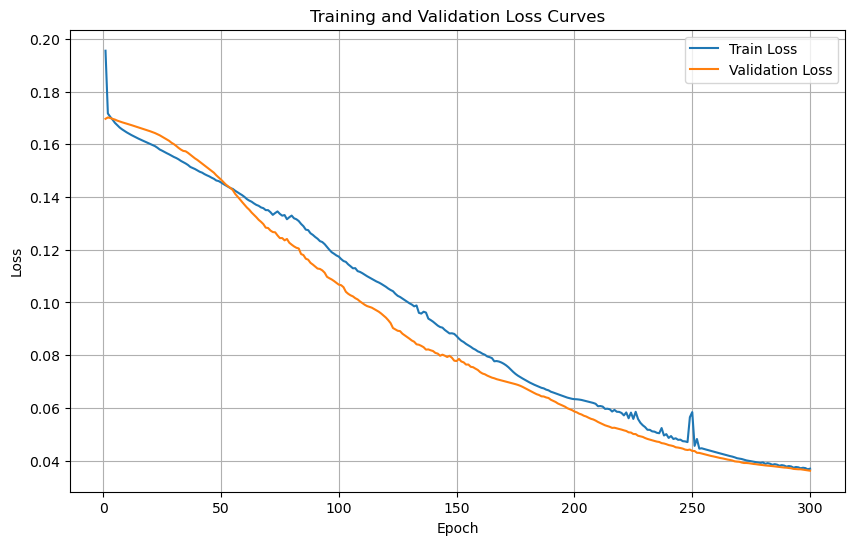

([0.19548361510038376,
  0.1716842359304428,
  0.1704105481505394,
  0.16934215277433395,
  0.16812642842531203,
  0.16722524136304856,
  0.16636059582233428,
  0.1656778547167778,
  0.1650705471634865,
  0.16451270431280135,
  0.16399115443229675,
  0.16349174022674562,
  0.1630253878235817,
  0.16257278829813004,
  0.16212883621454238,
  0.16169653177261353,
  0.16130401879549028,
  0.16090319007635118,
  0.16049602031707763,
  0.1600855502486229,
  0.15968971461057663,
  0.15928979873657226,
  0.15869961619377138,
  0.15801466941833497,
  0.15757686764001846,
  0.15707843571901323,
  0.15661561548709868,
  0.15617307871580124,
  0.1556823155283928,
  0.15518779098987578,
  0.15479014247655867,
  0.15429487705230713,
  0.153686443567276,
  0.15319746673107149,
  0.1527174034714699,
  0.15214263558387756,
  0.15139909327030182,
  0.150988107919693,
  0.15058679342269898,
  0.15008560210466385,
  0.14956397205591201,
  0.14923170924186707,
  0.1486804912984371,
  0.14823410883545876,
 

In [25]:
file_path = "spiral_train.csv"

hidden_size = 7
batch_size = 8
activation_fn = "relu"
num_epochs = 300
learning_rate = 0.1

eval_file_path = "spiral_valid.csv"
eval_batch_size = 4


train_loader = load_data(file_path, batch_size)
model = FFNNWithMSE(hidden_size, activation_fn)
eval_loader = load_data(eval_file_path, eval_batch_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

plot_loss_curves(model, train_loader, eval_loader, num_epochs, optimizer, criterion)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_decision_surface(model, test_loader, feature_range=(-2, 2), resolution=0.01):
    """
    Plots the decision surface of the model along with the test set observations.
    
    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        feature_range: Tuple (min, max) for the grid of features.
        resolution: Step size for the grid.
    """
    # Generate a grid of points
    x_min, x_max = feature_range
    y_min, y_max = feature_range
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten the grid to feed into the model
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
    
    # Get model predictions on the grid
    model.eval()
    with torch.no_grad():
        predictions = model(grid_points_tensor)
        predicted_labels = (predictions > 0.5).float().flatten()
    
    # Reshape predictions back to the grid shape
    Z = predicted_labels.reshape(xx.shape)
    
    # Plot decision surface
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    
    # Plot test data points
    for data, target in test_loader:
        data = data.numpy()
        target = target.numpy()
        plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='k', cmap=plt.cm.coolwarm, s=50, label='Test Data')
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Class 0',
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Class 1',
               markerfacecolor='blue', markersize=10)
    ]

    plt.title('Learned Decision Surface')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(handles=legend_elements, loc='upper right')
    plt.grid(True)
    plt.show()


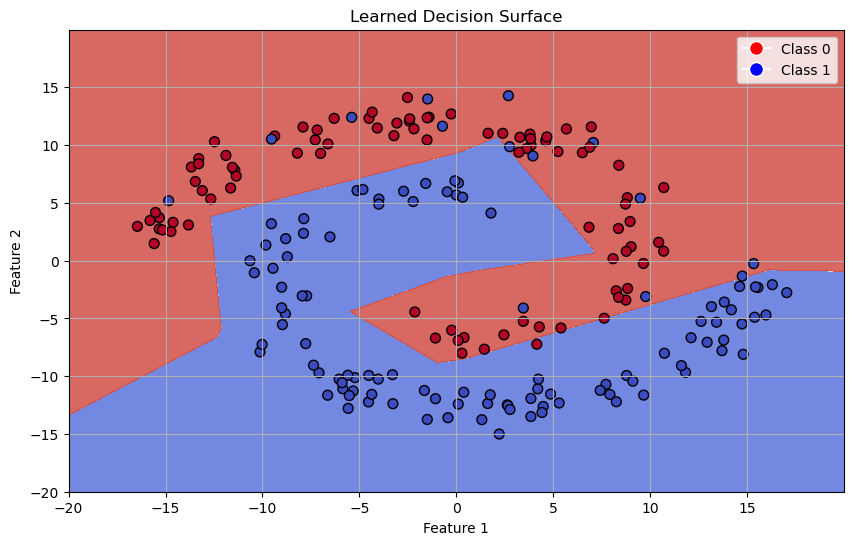

In [27]:
eval_file_path = "spiral_test.csv"
eval_batch_size = 4

test_loader = load_data(eval_file_path, eval_batch_size)
plot_decision_surface(model, test_loader, feature_range=(-20, 20), resolution=0.01)

## Q2 Response

### **i) xor**

#### a. 
- k=7
- batch_size=32
- num_epochs=50
- learning_rate=1
- activation_fn=relu

#### b.
<img src="loss_curves/mse/xor.png" width="500">

#### c.
0.955

#### d.
<img src="decision_surface/mse/xor.png" width="500">

#### e.
Increasing k improved performance up to k=7, but larger values caused slight overfitting. Larger batch sizes (e.g., 32) improved accuracy compared to smaller batches, likely due to more stable gradient updates. A learning rate of 1 enabled effective convergence, whereas lr=0.1 led to poor learning. Switching from sigmoid to ReLU further boosted accuracy to 96%, likely by avoiding vanishing gradients. These design choices collectively balanced model capacity, optimization, and generalization.

### **ii) center_surround**

#### a. 
- k=9
- batch_size=8
- num_epochs=50
- learning_rate=1
- activation_fn=tanh

#### b.
<img src="loss_curves/mse/center_surround.png" width="500">

#### c.
0.765

#### d.
<img src="decision_surface/mse/center_surround.png" width="500">

#### e.
Using the tanh activation function, accuracy improved with increasing hidden neurons (k), peaking at 95.5% for k=9. With a batch size of 8 and learning rate of 1, the model converged effectively, achieving consistently high performance. Satisfied with the results, further tuning was deemed unnecessary.

### **iii) two_gaussians**

#### a. 
- k=2
- batch_size=8
- num_epochs=50
- learning_rate=1
- activation_fn=tanh

#### b.
<img src="loss_curves/mse/two_gaussians.png" width="500">

#### c.
0.91

#### d.
<img src="decision_surface/mse/two_gaussians.png" width="500">

#### e.
We initially set the hyperparameters so that k=2, batch size=8, num epochs=50, learning rate=1, and activation function to be tanh. The accuracy of the model evaluated on the validation set turned out to be 0.97, and we decided that no further tuning is necessary.

### **iv) spiral**

#### a. 
- k=7
- batch_size=8
- num_epochs=300
- learning_rate=0.1
- activation_fn=relu

#### b.
<img src="loss_curves/mse/spiral.png" width="500">

#### c.
0.96

#### d.
<img src="decision_surface/mse/spiral.png" width="500">

#### e.
Through extensive tuning, I observed that increasing epochs and reducing the learning rate significantly improved performance with the tanh activation function, reaching 93% accuracy at k=7, batch_size=8, num_epochs=300, and lr=0.1. However, switching to ReLU at these settings further boosted accuracy to 95.5%, likely due to ReLU's better handling of gradient flow over many epochs. Smaller batch sizes ensured stable updates, while k=7 balanced model capacity and generalization. 

## 3. Manual Gradients and Updates

## 4. Regularizers

In [28]:
'''
Define model
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNNWithMSEAndReg(nn.Module):
    def __init__(self, hidden_size, activation_fn="sigmoid", lambda_norm=1e-4, lambda_ortho=1e-4):
        super(FFNNWithMSEAndReg, self).__init__()

        self.input_layer = nn.Linear(2, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, 1, bias=True)

        if activation_fn == "sigmoid":
            self.activation = torch.sigmoid
        elif activation_fn == "tanh":
            self.activation = torch.tanh
        elif activation_fn == "relu":
            self.activation = torch.relu

        self.lambda_norm = lambda_norm
        self.lambda_ortho = lambda_ortho

    def forward(self, x):
        hidden = self.activation(self.input_layer(x))
        output = torch.sigmoid(self.output_layer(hidden))

        return output
    
    def compute_regularization(self):
        # First regularizer: Penalize large input layer weights
        norm_reg = self.lambda_norm * torch.norm(self.input_layer.weight, p="fro")**2

        # Second regularizer: Encourage orthogonality (i.e., make dot product closr to zero)
        weight = self.input_layer.weight
        dot_products = torch.mm(weight, weight.T) # dot_products[i,j] represents the dot prod between ith and jth weight vectors
        identity = torch.eye(dot_products.size(0), device=dot_products.device) # represents the ideal orthogonal case (off-diagonal are 0)

        ortho_reg = self.lambda_ortho * torch.norm(dot_products - identity, p="fro")**2 # compute the deviation of the dot_products from the identity

        return norm_reg + ortho_reg


In [29]:
'''
Train model
'''

import torch.optim as optim

def train_model(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss = 0
        for data, target in train_loader:
            target = target.float().unsqueeze(1)
            optimizer.zero_grad() # reset gradients
            output = model(data) # forward pass
            primary_loss = criterion(output, target) # calculate loss
            reg_loss = model.compute_regularization()
            loss = primary_loss + reg_loss
 
            loss.backward() # backpropagation
            optimizer.step() # take step based on gradients and lr

            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

In [30]:
'''
Take in raw csv file path and batch size, return DataLoader object
'''

import csv
import torch
from torch.utils.data import DataLoader, TensorDataset

def load_data(file_path, batch_size):
    inputs = []
    labels = []

    with open(file_path, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header row
        for row in reader:
            labels.append(float(row[0]))
            inputs.append([float(row[1]), float(row[2])])

    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(inputs_tensor, labels_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader


In [31]:
'''
Train model with train set. 
Hyperparameters: hidden_size, batch_size, num_epochs, learning_rate
'''
import torch

torch.manual_seed(42)

file_path = "xor_train.csv"

hidden_size = 3
batch_size = 5
activation_fn = "relu"
num_epochs = 100
learning_rate = 0.1
lambda_norm = 0
lambda_orth = 0

train_loader = load_data(file_path, batch_size)
model = FFNNWithMSEAndReg(hidden_size, activation_fn, lambda_norm=lambda_norm, lambda_ortho=lambda_orth)

train_model(model, train_loader, num_epochs, learning_rate)

Epoch 1/100, Loss: 0.2910
Epoch 2/100, Loss: 0.2621
Epoch 3/100, Loss: 0.2534
Epoch 4/100, Loss: 0.2505
Epoch 5/100, Loss: 0.2486
Epoch 6/100, Loss: 0.2471
Epoch 7/100, Loss: 0.2455
Epoch 8/100, Loss: 0.2443
Epoch 9/100, Loss: 0.2430
Epoch 10/100, Loss: 0.2415
Epoch 11/100, Loss: 0.2399
Epoch 12/100, Loss: 0.2378
Epoch 13/100, Loss: 0.2359
Epoch 14/100, Loss: 0.2334
Epoch 15/100, Loss: 0.2308
Epoch 16/100, Loss: 0.2281
Epoch 17/100, Loss: 0.2253
Epoch 18/100, Loss: 0.2220
Epoch 19/100, Loss: 0.2206
Epoch 20/100, Loss: 0.2169
Epoch 21/100, Loss: 0.2135
Epoch 22/100, Loss: 0.2109
Epoch 23/100, Loss: 0.2075
Epoch 24/100, Loss: 0.2043
Epoch 25/100, Loss: 0.1990
Epoch 26/100, Loss: 0.1932
Epoch 27/100, Loss: 0.1868
Epoch 28/100, Loss: 0.1812
Epoch 29/100, Loss: 0.1742
Epoch 30/100, Loss: 0.1678
Epoch 31/100, Loss: 0.1609
Epoch 32/100, Loss: 0.1537
Epoch 33/100, Loss: 0.1483
Epoch 34/100, Loss: 0.1435
Epoch 35/100, Loss: 0.1373
Epoch 36/100, Loss: 0.1323
Epoch 37/100, Loss: 0.1270
Epoch 38/1

In [32]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # if output exceeds threshold 0.5, classify as 1
            preds = (output > 0.5).float()
            all_preds.extend(preds.numpy())
            all_targets.extend(target.numpy())

    all_preds = torch.tensor(all_preds).squeeze()
    all_targets = torch.tensor(all_targets)
    
    correct = (all_preds == all_targets).sum().item()
    total = len(all_targets)
    accuracy = correct / total
    
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [33]:
eval_file_path = "xor_valid.csv"
eval_batch_size = 4

eval_loader = load_data(eval_file_path, eval_batch_size)
evaluate_model(model, eval_loader)

Accuracy: 0.9150


0.915

In [34]:
import matplotlib.pyplot as plt

def plot_loss_curves(model, train_loader, val_loader, num_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_train_loss = 0.0
        for data, target in train_loader:
            target = target.squeeze()
            optimizer.zero_grad()
            output = model(data).squeeze()
            primary_loss = criterion(output, target)
            reg_loss = model.compute_regularization()
            loss = primary_loss + reg_loss
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                target = target.squeeze()
                output = model(data).squeeze()
                loss = criterion(output, target)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses


Epoch 1/100 - Train Loss: 0.2569, Validation Loss: 0.2654
Epoch 2/100 - Train Loss: 0.2519, Validation Loss: 0.2606
Epoch 3/100 - Train Loss: 0.2469, Validation Loss: 0.2566
Epoch 4/100 - Train Loss: 0.2428, Validation Loss: 0.2533
Epoch 5/100 - Train Loss: 0.2388, Validation Loss: 0.2499
Epoch 6/100 - Train Loss: 0.2338, Validation Loss: 0.2470
Epoch 7/100 - Train Loss: 0.2276, Validation Loss: 0.2421
Epoch 8/100 - Train Loss: 0.2219, Validation Loss: 0.2369
Epoch 9/100 - Train Loss: 0.2158, Validation Loss: 0.2328
Epoch 10/100 - Train Loss: 0.2099, Validation Loss: 0.2280
Epoch 11/100 - Train Loss: 0.2039, Validation Loss: 0.2237
Epoch 12/100 - Train Loss: 0.1980, Validation Loss: 0.2177
Epoch 13/100 - Train Loss: 0.1916, Validation Loss: 0.2114
Epoch 14/100 - Train Loss: 0.1854, Validation Loss: 0.2073
Epoch 15/100 - Train Loss: 0.1799, Validation Loss: 0.2014
Epoch 16/100 - Train Loss: 0.1738, Validation Loss: 0.1973
Epoch 17/100 - Train Loss: 0.1684, Validation Loss: 0.1916
Epoch 

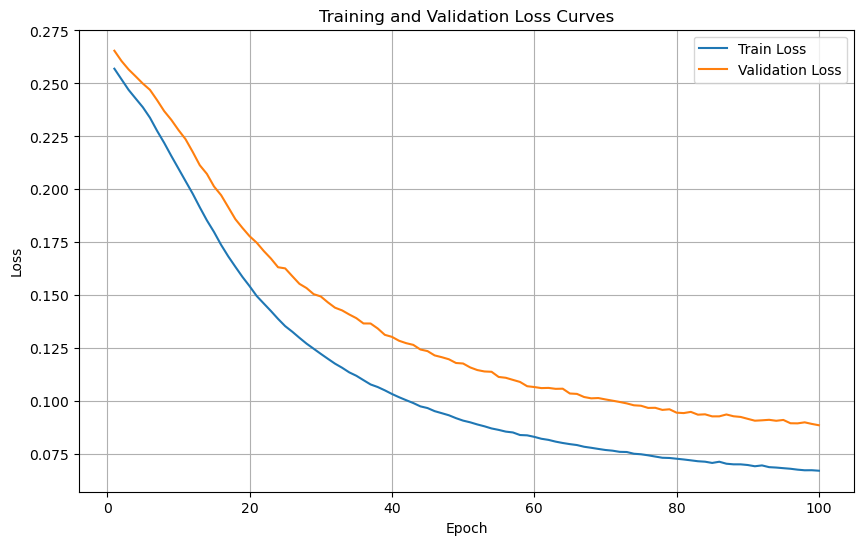

([0.25694437205791476,
  0.2519331538677216,
  0.24694348573684693,
  0.24283307015895844,
  0.2387573653459549,
  0.23381334841251372,
  0.22763554990291596,
  0.22194308936595916,
  0.21577995657920837,
  0.2098564499616623,
  0.20390926122665406,
  0.19800382494926452,
  0.1915582412481308,
  0.18537660598754882,
  0.17989905774593354,
  0.17380072951316833,
  0.16839259564876558,
  0.16347716361284256,
  0.15868119567632674,
  0.15432896077632904,
  0.1496793058514595,
  0.14612155079841613,
  0.14259513944387436,
  0.13888841152191161,
  0.13546940475702285,
  0.13284041076898576,
  0.1299765807390213,
  0.12722495198249817,
  0.12481646835803986,
  0.12240323185920715,
  0.1200654385983944,
  0.11777186274528503,
  0.11583992049098014,
  0.11366500109434127,
  0.11205032765865326,
  0.10999126344919205,
  0.10795716032385826,
  0.10673993647098541,
  0.10518069326877594,
  0.1034622247517109,
  0.10193551912903785,
  0.10052856177091599,
  0.09918595045804977,
  0.097609626203775

In [35]:
file_path = "xor_train.csv"

# Hyperparams
hidden_size = 3
batch_size = 8
activation_fn = "relu"
num_epochs = 100
learning_rate = 0.1
lambda_norm = 1e-2
lambda_orth = 1e-2

eval_file_path = "xor_valid.csv"
eval_batch_size = 4


train_loader = load_data(file_path, batch_size)
model = FFNNWithMSEAndReg(hidden_size, activation_fn)
eval_loader = load_data(eval_file_path, eval_batch_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

plot_loss_curves(model, train_loader, eval_loader, num_epochs, optimizer, criterion)


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_decision_surface(model, test_loader, feature_range=(-2, 2), resolution=0.01):
    # Generate a grid of points
    x_min, x_max = feature_range
    y_min, y_max = feature_range
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten the grid to feed into the model
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
    
    # Get model predictions on the grid
    model.eval()
    with torch.no_grad():
        hidden_layer_output = model.activation(model.input_layer(grid_points_tensor)) # hidden layer outputs
        final_output = torch.sigmoid(model.output_layer(hidden_layer_output))
    hidden_layer_outputs = (hidden_layer_output > 0.5).numpy()
    predicted_labels = (final_output > 0.5).float().flatten()

    hidden_size = hidden_layer_output.shape[1]
    for i in range(hidden_size):
        Z_hidden = hidden_layer_outputs[:, i].reshape(xx.shape)
        plt.figure(figsize=(8, 6))
        plt.contourf(xx, yy, Z_hidden, levels=50, cmap="coolwarm", alpha=0.6)
        plt.contour(xx, yy, Z_hidden, levels=[0.5], colors="black", linewidths=2, linestyles="--")
        
        # Plot test data points
        for data, target in test_loader:
            data = data.numpy()
            target = target.numpy()
            plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor="k", cmap=plt.cm.coolwarm, s=50)
        
        plt.title(f'Decision Surface of Hidden Neuron {i+1}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.colorbar(label='Activation Value')
        plt.grid(True)
        plt.show()

    # Plot the final decision surface
    Z_final = predicted_labels.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z_final, levels=50, cmap="coolwarm", alpha=0.6)
    plt.contour(xx, yy, Z_final, levels=[0.5], colors="black", linewidths=2)
    
    # Plot test data points
    for data, target in test_loader:
        data = data.numpy()
        target = target.numpy()
        plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor="k", cmap=plt.cm.coolwarm, s=50)
    
    plt.title('Final Decision Surface')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Prediction Probability')
    plt.grid(True)
    plt.show()

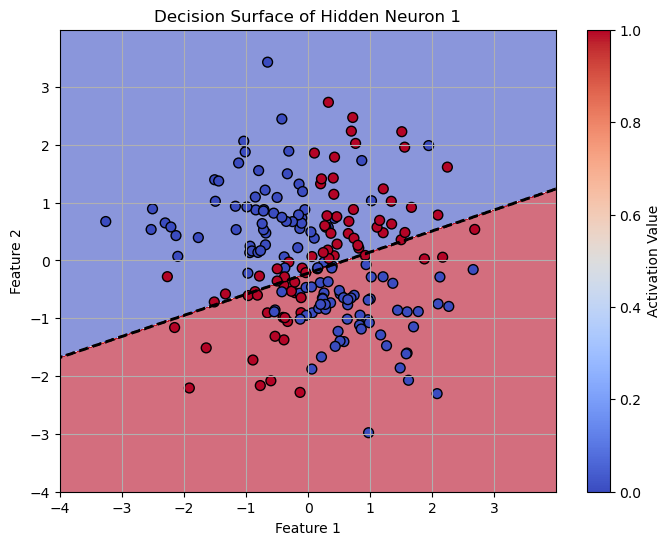

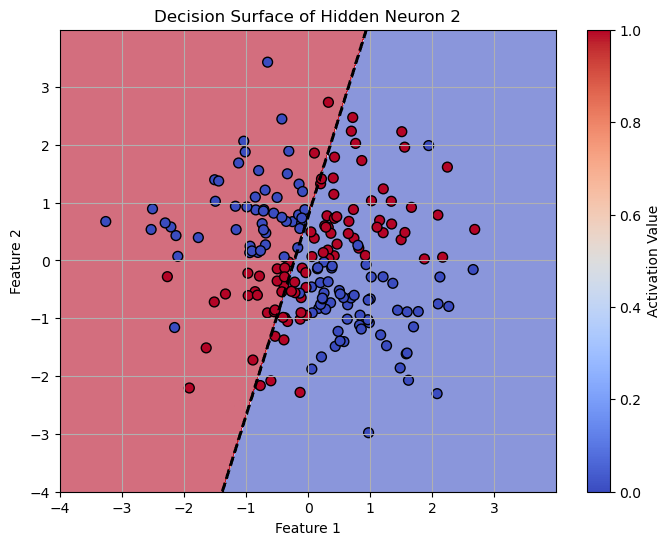

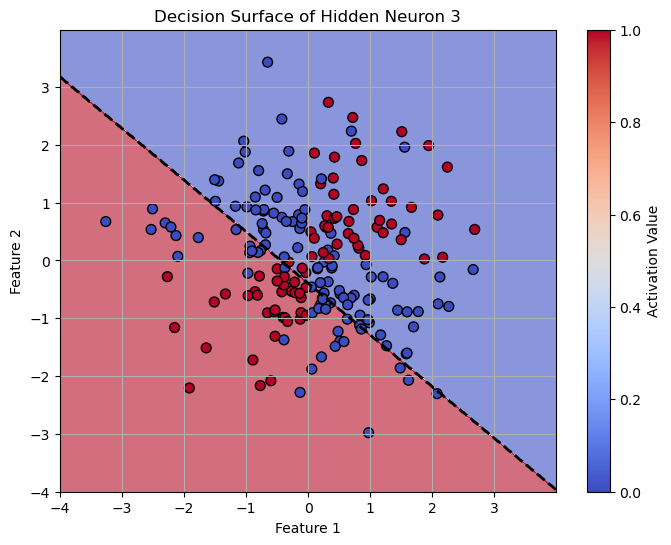

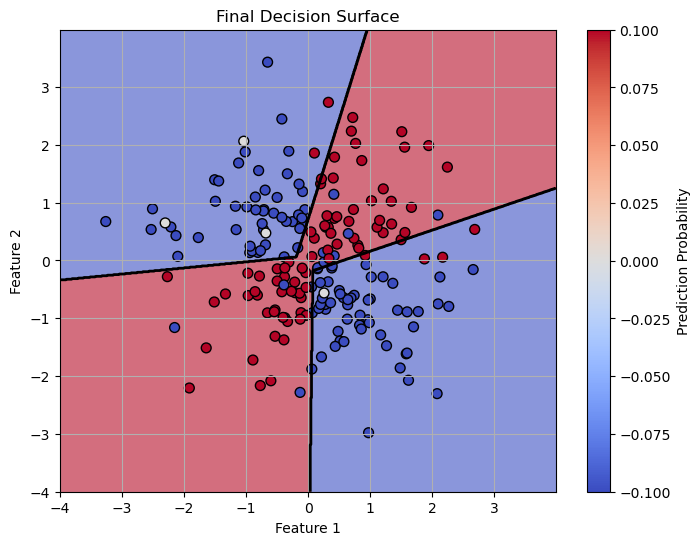

In [37]:
eval_file_path = "xor_test.csv"
eval_batch_size = 4

test_loader = load_data(eval_file_path, eval_batch_size)
plot_decision_surface(model, test_loader, feature_range=(-4, 4), resolution=0.01)

## Q4 Response

### **xor with k=3**

#### a. 
- k=3
- batch_size=5
- num_epochs=100
- learning_rate=0.1
- activation_fn=relu

#### b.
<img src="loss_curves/xor_with_reg.png" width="500">

#### c.
0.805

#### d.
##### **Regularized** Dataset: XOR, Nodes: 3, Cost Function: MSE
<img src="decision_surface/mse_with_reg/hidden_1.png" width="300">
<img src="decision_surface/mse_with_reg/hidden_2.png" width="300">
<img src="decision_surface/mse_with_reg/hidden_3.png" width="300">
<img src="decision_surface/mse_with_reg/final.png" width="300">

##### **Unregularized** Dataset: XOR, Nodes: 3, Cost Function: MSE
<img src="decision_surface/mse_without_reg/hidden_1.png" width="300">
<img src="decision_surface/mse_without_reg/hidden_2.png" width="300">
<img src="decision_surface/mse_without_reg/hidden_3.png" width="300">
<img src="decision_surface/mse_without_reg/final.png" width="300">

#### e.
The interesting hyperparameters to tune here are the normalization and orthogonalization regularization values. These have an interesting interplay with the batch size too. We are using the xor dataset, which naturally has orthogonal classes, so we believed weighting the orthogonalization regularizer more heavily would prove beneficial, as it would force the neural network to work harder to find orthogonal boundaries for the neurons.
Both regularization hyperparameters are computed after a batch is completed, so the more batches we compute, the more of an effect the regularizer should have. But, we need the batches to be large enough to actually be representative of the input data so that the classification boundaries the neural network learns are representative.
We found that a batch size of 5, with a normalization regularizer of 1e-2 and an orthogonalization regularizer of 1e-1 provided us with a strong classification boundary for the xor dataset, a traditionally very difficult-to-classify dataset by perceptron-based algorithms.